# Deep Neural Network for MNIST Classification

We'll apply all the knowledge from the lectures in this section to write a deep neural network. The problem we've chosen is referred to as the "Hello World" of deep learning because for most students it is the first deep learning algorithm they see.

The dataset is called MNIST and refers to handwritten digit recognition. You can find more about it on Yann LeCun's website (Director of AI Research, Facebook). He is one of the pioneers of what we've been talking about and of more complex approaches that are widely used today, such as covolutional neural networks (CNNs). 

The dataset provides 70,000 images (28x28 pixels) of handwritten digits (1 digit per image). 

The goal is to write an algorithm that detects which digit is written. Since there are only 10 digits (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), this is a classification problem with 10 classes. 

Our goal would be to build a neural network with 2 hidden layers.

## Import the relevant packages

In [104]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from tensorflow.keras import layers, models, optimizers



# TensorFLow includes a data provider for MNIST that we'll use.
# It comes with the tensorflow-datasets module, therefore, if you haven't please install the package using
# pip install tensorflow-datasets 
# or
# conda install tensorflow-datasets

import tensorflow_datasets as tfds

# these datasets will be stored in C:\Users\*USERNAME*\tensorflow_datasets\...
# the first time you download a dataset, it is stored in the respective folder 
# every other time, it is automatically loading the copy on your computer 

In [105]:
TARGET_COLUMN_NAME = "Status"

df = pd.read_csv("./dataset/Loan_default.csv")
n_class = df["Status"].nunique()

df

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,...,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,173555,2019,cf,Sex Not Available,nopre,type1,p3,l1,nopc,nob/c,...,CIB,659,EXP,55-64,to_inst,71.792763,south,direct,0,48.0
148666,173556,2019,cf,Male,nopre,type1,p1,l1,nopc,nob/c,...,CIB,569,CIB,25-34,not_inst,74.428934,south,direct,0,15.0
148667,173557,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,CIB,702,EXP,45-54,not_inst,61.332418,North,direct,0,49.0
148668,173558,2019,cf,Female,nopre,type1,p4,l1,nopc,nob/c,...,EXP,737,EXP,55-64,to_inst,70.683453,North,direct,0,29.0


In [106]:
float_columns = []
for col in df.columns:
    if df[col].dtype == 'float64':
        float_columns.append(col)
float_columns

['rate_of_interest',
 'Interest_rate_spread',
 'Upfront_charges',
 'term',
 'property_value',
 'income',
 'LTV',
 'dtir1']

In [107]:
text_columns = ["loan_type", "loan_purpose", "credit_type", "co-applicant_credit_type", "age"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

In [108]:
df = df[text_columns + float_columns + [TARGET_COLUMN_NAME]]
for col in text_columns:
    df = pd.get_dummies(df, columns=[col])

for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

df = df[list(set(df.columns)-set([TARGET_COLUMN_NAME])) + [TARGET_COLUMN_NAME]]
df = df.fillna(0)
df

,Upfront_charges,term,loan_type_type3,credit_type_CIB,age_55-64,Interest_rate_spread,age_65-74,credit_type_CRIF,age_>74,LTV,...,loan_type_type2,property_value,credit_type_EQUI,age_25-34,co-applicant_credit_type_EXP,income,loan_purpose_p1,dtir1,loan_purpose_p3,Status
0,0.00,360.0,0,0,0,0.0000,0,0,0,98.728814,...,0,118000.0,0,1,0,1740.0,1,45.0,0,1
1,0.00,360.0,0,0,1,0.0000,0,0,0,0.000000,...,1,0.0,1,0,1,4980.0,1,0.0,0,1
2,595.00,360.0,0,0,0,0.2000,0,0,0,80.019685,...,0,508000.0,0,0,0,9480.0,1,46.0,0,0
3,0.00,360.0,0,0,0,0.6810,0,0,0,69.376900,...,0,658000.0,0,0,0,11880.0,0,42.0,0,0
4,0.00,360.0,0,0,0,0.3042,0,1,0,91.886544,...,0,758000.0,0,1,1,10440.0,1,39.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148665,9960.00,180.0,0,1,1,0.2571,0,0,0,71.792763,...,0,608000.0,0,0,1,7860.0,0,48.0,1,0
148666,0.00,360.0,0,1,0,0.8544,0,0,0,74.428934,...,0,788000.0,0,1,0,7140.0,1,15.0,0,0
148667,1226.64,180.0,0,1,0,0.0816,0,0,0,61.332418,...,0,728000.0,0,0,1,6900.0,0,49.0,0,0
148668,4323.33,180.0,0,0,1,0.5824,0,0,0,70.683453,...,0,278000.0,0,0,1,7140.0,0,29.0,0,0


In [109]:
X_train, X_test, y_train, y_test = train_test_split(df.iloc[:, :-1], df[TARGET_COLUMN_NAME], test_size=0.10, random_state=42)
y_test

24912     0
147068    0
123284    0
53610     0
39672     0
         ..
109473    0
10890     0
115797    1
58966     0
8967      0
Name: Status, Length: 14867, dtype: int64

In [110]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.activations import tanh, softmax
from tensorflow.keras.callbacks import EarlyStopping

# Set up the model parameters and data
input_layer_neurons = X_train.shape[1]
hidden_layer_neurons = input_layer_neurons * 2
output_layer_neurons = n_class

# Build the model
model = models.Sequential([
    layers.InputLayer(input_shape=(input_layer_neurons,)),
    layers.Dense(hidden_layer_neurons, activation='tanh', kernel_initializer=tf.keras.initializers.GlorotUniform()),
    layers.Dense(output_layer_neurons, activation='softmax', kernel_initializer=tf.keras.initializers.GlorotUniform())
])

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Early stopping callback for validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, 
                    epochs=30, 
                    batch_size=32, 
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping])

# Print final results
for epoch in range(len(history.history['loss'])):
    print(f"Epoch {epoch+1}/{len(history.history['loss'])}, "
          f"Loss: {history.history['loss'][epoch]}, "
          f"Validation Accuracy: {history.history['val_accuracy'][epoch]}, "
          f"Validation Loss: {history.history['val_loss'][epoch]}")


c:\Users\Paulina\Desktop\test_actionsv2\venv\Lib\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/30
4182/4182 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.8519 - loss: 0.4063 - val_accuracy: 0.8608 - val_loss: 0.3895
Epoch 2/30
4182/4182 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8538 - loss: 0.4009 - val_accuracy: 0.8608 - val_loss: 0.3881
Epoch 3/30
4182/4182 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.8529 - loss: 0.4019 - val_accuracy: 0.8608 - val_loss: 0.3884
Epoch 4/30
4182/4182 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8558 - loss: 0.3974 - val_accuracy: 0.8608 - val_loss: 0.3908
Epoch 5/30
4182/4182 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.8555 - loss: 0.3979 - val_accuracy: 0.8608 - val_loss: 0.3884
Epoch 6/30
4182/4182 ━━━━━━━━━━━━━━━━━━━━ 20s 4ms/step - accuracy: 0.8563 - loss: 0.3969 - val_accuracy: 0.8608 - val_loss: 0.3889
Epoch 7/30
4182/4182 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.8544 - loss: 0.3998 - val_accuracy: 0.8608 - val_loss: 0.3920
Epoch 1/7, Loss: 0.4017195999622345, Validation Accuracy: 0.8607654571533203, Valid

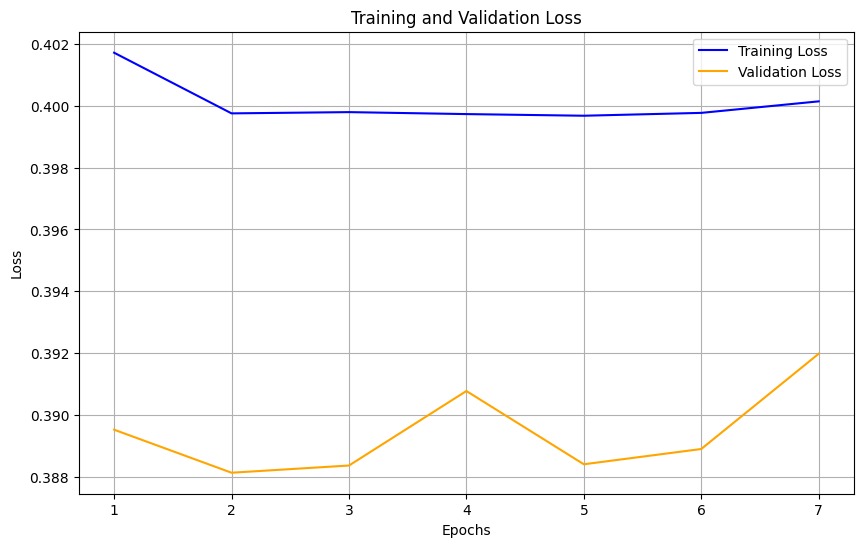

In [111]:
import matplotlib.pyplot as plt

# Extract loss and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot for loss vs. epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss', color='blue')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


## Data

That's where we load and preprocess our data.

In [112]:
# remember the comment from above
# these datasets will be stored in C:\Users\*USERNAME*\tensorflow_datasets\...
# the first time you download a dataset, it is stored in the respective folder 
# every other time, it is automatically loading the copy on your computer 

# tfds.load actually loads a dataset (or downloads and then loads if that's the first time you use it) 
# in our case, we are interesteed in the MNIST; the name of the dataset is the only mandatory argument
# there are other arguments we can specify, which we can find useful
# mnist_dataset = tfds.load(name='mnist', as_supervised=True)
# mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)
# with_info=True will also provide us with a tuple containing information about the version, features, number of samples
# we will use this information a bit below and we will store it in mnist_info

# as_supervised=True will load the dataset in a 2-tuple structure (input, target) 
# alternatively, as_supervised=False, would return a dictionary
# obviously we prefer to have our inputs and targets separated 

# once we have loaded the dataset, we can easily extract the training and testing dataset with the built references
# mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

# by default, TF has training and testing datasets, but no validation sets
# thus we must split it on our own

# we start by defining the number of validation samples as a % of the train samples
# this is also where we make use of mnist_info (we don't have to count the observations)
num_validation_samples = 0.1 * y_train.shape[0]
# let's cast this number to an integer, as a float may cause an error along the way
num_validation_samples = tf.cast(num_validation_samples, tf.int64)

# let's also store the number of test samples in a dedicated variable (instead of using the mnist_info one)
num_test_samples = y_test.shape[0]
# once more, we'd prefer an integer (rather than the default float)
num_test_samples = tf.cast(num_test_samples, tf.int64)


# normally, we would like to scale our data in some way to make the result more numerically stable
# in this case we will simply prefer to have inputs between 0 and 1
# let's define a function called: scale, that will take an MNIST image and its label
# def scale(image, label):
#     # we make sure the value is a float
#     image = tf.cast(image, tf.float32)
#     # since the possible values for the inputs are 0 to 255 (256 different shades of grey)
#     # if we divide each element by 255, we would get the desired result -> all elements will be between 0 and 1 
#     image /= 255.

#     return image, label


# the method .map() allows us to apply a custom transformation to a given dataset
# we have already decided that we will get the validation data from mnist_train, so 
# scaled_train_and_validation_data = mnist_train.map(scale)

# finally, we scale and batch the test data
# we scale it so it has the same magnitude as the train and validation
# there is no need to shuffle it, because we won't be training on the test data
# there would be a single batch, equal to the size of the test data
# test_data = mnist_test.map(scale)


# let's also shuffle the data

BUFFER_SIZE = 10000
# this BUFFER_SIZE parameter is here for cases when we're dealing with enormous datasets
# then we can't shuffle the whole dataset in one go because we can't fit it all in memory
# so instead TF only stores BUFFER_SIZE samples in memory at a time and shuffles them
# if BUFFER_SIZE=1 => no shuffling will actually happen
# if BUFFER_SIZE >= num samples => shuffling is uniform
# BUFFER_SIZE in between - a computational optimization to approximate uniform shuffling

# luckily for us, there is a shuffle method readily available and we just need to specify the buffer size
shuffled_train_and_validation_data = scaled_train_and_validation_data.shuffle(BUFFER_SIZE)

# once we have scaled and shuffled the data, we can proceed to actually extracting the train and validation
# our validation data would be equal to 10% of the training set, which we've already calculated
# we use the .take() method to take that many samples
# finally, we create a batch with a batch size equal to the total number of validation samples
validation_data = shuffled_train_and_validation_data.take(num_validation_samples)

# similarly, the train_data is everything else, so we skip as many samples as there are in the validation dataset
train_data = shuffled_train_and_validation_data.skip(num_validation_samples)

# determine the batch size
BATCH_SIZE = 100

# we can also take advantage of the occasion to batch the train data
# this would be very helpful when we train, as we would be able to iterate over the different batches
train_data = train_data.batch(BATCH_SIZE)

validation_data = validation_data.batch(num_validation_samples)

# batch the test data
test_data = test_data.batch(num_test_samples)


# takes next batch (it is the only batch)
# because as_supervized=True, we've got a 2-tuple structure
validation_inputs, validation_targets = next(iter(validation_data))

## Model

### Outline the model
When thinking about a deep learning algorithm, we mostly imagine building the model. So, let's do it :)

In [113]:
input_size = 784
output_size = 10
# Use same hidden layer size for both hidden layers. Not a necessity.
hidden_layer_size = 50
    
# define how the model will look like
model = tf.keras.Sequential([
    
    # the first layer (the input layer)
    # each observation is 28x28x1 pixels, therefore it is a tensor of rank 3
    # since we don't know CNNs yet, we don't know how to feed such input into our net, so we must flatten the images
    # there is a convenient method 'Flatten' that simply takes our 28x28x1 tensor and orders it into a (None,) 
    # or (28x28x1,) = (784,) vector
    # this allows us to actually create a feed forward neural network
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)), # input layer
    
    # tf.keras.layers.Dense is basically implementing: output = activation(dot(input, weight) + bias)
    # it takes several arguments, but the most important ones for us are the hidden_layer_size and the activation function
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 1st hidden layer
    tf.keras.layers.Dense(hidden_layer_size, activation='relu'), # 2nd hidden layer
    
    # the final layer is no different, we just make sure to activate it with softmax
    tf.keras.layers.Dense(output_size, activation='softmax') # output layer
])

c:\Users\Paulina\Desktop\test_actionsv2\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Choose the optimizer and the loss function

In [114]:
# we define the optimizer we'd like to use, 
# the loss function, 
# and the metrics we are interested in obtaining at each iteration
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### Training
That's where we train the model we have built.

In [115]:
# determine the maximum number of epochs
NUM_EPOCHS = 5

# we fit the model, specifying the
# training data
# the total number of epochs
# and the validation data we just created ourselves in the format: (inputs,targets)
model.fit(train_data, epochs=NUM_EPOCHS, validation_data=(validation_inputs, validation_targets), verbose =2)

Epoch 1/5


467/467 - 7s - 14ms/step - accuracy: 0.8782 - loss: 0.4402 - val_accuracy: 0.9361 - val_loss: 0.2300
Epoch 2/5
467/467 - 5s - 11ms/step - accuracy: 0.9430 - loss: 0.1965 - val_accuracy: 0.9513 - val_loss: 0.1699
Epoch 3/5
467/467 - 3s - 7ms/step - accuracy: 0.9552 - loss: 0.1532 - val_accuracy: 0.9614 - val_loss: 0.1352
Epoch 4/5
467/467 - 4s - 8ms/step - accuracy: 0.9628 - loss: 0.1252 - val_accuracy: 0.9642 - val_loss: 0.1191
Epoch 5/5
467/467 - 4s - 8ms/step - accuracy: 0.9691 - loss: 0.1058 - val_accuracy: 0.9685 - val_loss: 0.1084


## Test the model

As we discussed in the lectures, after training on the training data and validating on the validation data, we test the final prediction power of our model by running it on the test dataset that the algorithm has NEVER seen before.

It is very important to realize that fiddling with the hyperparameters overfits the validation dataset. 

The test is the absolute final instance. You should not test before you are completely done with adjusting your model.

If you adjust your model after testing, you will start overfitting the test dataset, which will defeat its purpose.

In [116]:
test_loss, test_accuracy = model.evaluate(test_data)

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [ ]:
# We can apply some nice formatting if we want to
print('Test loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))

Test loss: 0.11. Test accuracy: 96.61%


Using the initial model and hyperparameters given in this notebook, the final test accuracy should be roughly around 97%.

Each time the code is rerun, we get a different accuracy as the batches are shuffled, the weights are initialized in a different way, etc.

Finally, we have intentionally reached a suboptimal solution, so you can have space to build on it.